In [1]:
# import libraries
import numpy as np
from scipy.spatial import cKDTree
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import random
import os

In [2]:
# read the geopandas file
data_path = "../data/"
fpath = os.path.join(data_path, "2008_presidential_precinct_counts.shp")

In [3]:
geo_test = gpd.read_file(fpath)

In [4]:
geo_test.head()

,OBJECTID_1,OBJECTID,AV,NDV,NRV,P2008_D,P2008_R,obama_shar,Shape_Leng,pres_twopa,Shape_Le_1,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,Shape_Le_2,Shape_Area,geometry
0,1,32136.0,0.600831,1597.610000,1061.390000,1891.0,768.0,0.711170,0.166011,2659.0,0.166011,0500000US48453,48,453,Travis,County,990.202,17200.086164,5.647712e+06,"POLYGON ((1717728.210 7368333.015, 1717777.958..."
1,2,32137.0,0.482888,917.005000,981.995000,1101.0,798.0,0.579779,0.118595,1899.0,0.118595,0500000US48201,48,201,Harris,County,1703.478,12180.009183,5.526007e+06,"POLYGON ((1912654.744 7312563.597, 1912663.706..."
2,3,32139.0,0.586967,834.080000,586.920000,924.0,497.0,0.650246,0.069253,1421.0,0.069253,0500000US48453,48,453,Travis,County,990.202,7211.161239,2.130211e+06,"POLYGON ((1714250.972 7355096.188, 1714202.932..."
3,4,32141.0,0.706522,0.706522,0.293478,1.0,0.0,1.000000,0.049011,1.0,0.049011,0500000US48029,48,029,Bexar,County,1239.820,4821.716927,7.636421e+04,"POLYGON ((1669729.218 7263595.876, 1669410.636..."
4,5,32142.0,0.499725,682.124000,682.876000,780.0,585.0,0.571429,0.078242,1365.0,0.078242,0500000US48029,48,029,Bexar,County,1239.820,8085.096017,1.629649e+06,"POLYGON ((1629491.358 7265195.230, 1629492.219..."


In [5]:
# Take out NC state to test all functions
nc = geo_test[geo_test.STATE == "37"]

In [6]:
nc.head()

,OBJECTID_1,OBJECTID,AV,NDV,NRV,P2008_D,P2008_R,obama_shar,Shape_Leng,pres_twopa,Shape_Le_1,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,Shape_Le_2,Shape_Area,geometry
73827,73828,136342.0,0.437901,440.528,565.4720,298.0,698.0,0.299197,0.432445,996.0,0.432445,0500000US37017,37,017,Bladen,County,874.328,43184.571989,7.944124e+07,"POLYGON ((3436401.698 8009685.933, 3436452.885..."
73828,73829,136343.0,0.595414,297.707,202.2930,222.0,272.0,0.449393,0.342965,494.0,0.342965,0500000US37017,37,017,Bladen,County,874.328,34629.553738,7.298289e+07,"POLYGON ((3444525.236 8004133.847, 3444490.550..."
73829,73830,136344.0,0.509491,800.920,771.0800,550.0,1004.0,0.353925,0.411643,1554.0,0.411643,0500000US37017,37,017,Bladen,County,874.328,40459.041781,8.755897e+07,"POLYGON ((3438790.628 8019178.195, 3438821.261..."
73830,73831,136346.0,0.637974,520.586,295.4140,444.0,366.0,0.548148,0.409558,810.0,0.409558,0500000US37017,37,017,Bladen,County,874.328,41139.384816,8.224659e+07,"POLYGON ((3447130.391 8014526.100, 3447170.051..."
73831,73832,136347.0,0.904550,849.373,89.6274,826.0,111.0,0.881537,0.687864,937.0,0.687864,0500000US37017,37,017,Bladen,County,874.328,67658.312952,1.936219e+08,"POLYGON ((3485199.351 8004369.189, 3485197.369..."


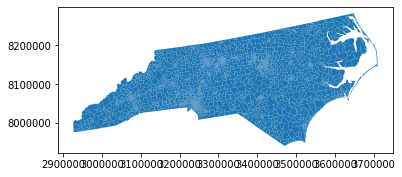

In [7]:
nc.plot()

In [8]:
def _make_random_points(number, polygon):
    #Generates number of uniformly distributed points in polygon
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points


In [9]:
# Make master dataframe
gf_nc = pd.DataFrame(columns=['Dem','KnnShrDem', 'geometry'])
election = "P2008_"
prob=0.01
for index, row in nc.iterrows():
    # Loop over dems and republicans
    for party in ['D', 'R']:
        points_to_add =  np.random.binomial(int(row[election + party]), prob)
        points = _make_random_points(points_to_add, row.geometry)
        for point in points:
            if party == "D": 
                dem_value = 1
            else: 
                dem_value = 0

            gf_nc = gf_nc.append({'Dem': dem_value, 'KnnShrDem': None, 'geometry': point}, ignore_index=True)

gf_nc['geometry'] = gf_nc['geometry'].astype(str)
gf_nc['geometry'] = gf_nc['geometry'].str.strip()
gf_nc['geometry'] = gf_nc['geometry'].str.replace('POINT \(', '')
gf_nc['geometry'] = gf_nc['geometry'].str.replace('\)', '')
gf_nc[['x', 'y']] = gf_nc.geometry.str.split(' ', expand=True)
gf_nc.drop(columns=['geometry'], inplace=True)

In [10]:
gf_nc

,Dem,KnnShrDem,x,y
0,0,None,3433088.549009719,8002392.764286341
1,0,None,3429885.629765455,8002132.368704657
2,0,None,3428971.271201013,8007623.506570096
3,0,None,3432492.851643822,8007084.509193985
4,0,None,3430656.540919108,8010089.326552849
...,...,...,...,...
42434,1,None,3442173.334010176,8228845.02579063
42435,1,None,3445816.089508363,8230626.03752312
42436,0,None,3444254.294501491,8227656.337020247
42437,0,None,3442701.377775544,8228940.75637726


In [12]:
def calculate_voter_knn(voter_points, k, target_column='Dem'):
    """
        Calculation composition of nearest neigbhors.

        :param voter_points: :class:`geopandas.GeoDataFrame`.
              GeoDataFrame of voter points
        :param k: Num nearest neighbors to consider.
        :param target_column: Feature to average
    """

    tree = cKDTree(list(zip(voter_points.x, voter_points.y)))

    dd, ii = tree.query(list(zip(voter_points.x, voter_points.y)), k=k)

#     dd = None

    voter_points1 = voter_points.copy()
    its = 0
    for index, row in voter_points1.iterrows():
        row[f'KnnShr{target_column}'] = sum(voter_points1[target_column][ii[its]])/k
        its+=1


    voter_points1[target_column] = pd.to_numeric(voter_points1[target_column])
    voter_points1[f"KnnShr{target_column}"] = pd.to_numeric(voter_points1[f"KnnShr{target_column}"])
    
    return voter_points1

In [13]:
# Calculate voter knn on nc dataframe
gf_nc_new = calculate_voter_knn(gf_nc, k=2)


In [14]:
gf_nc_new

,Dem,KnnShrDem,x,y
0,0,0.0,3433088.549009719,8002392.764286341
1,0,0.5,3429885.629765455,8002132.368704657
2,0,0.0,3428971.271201013,8007623.506570096
3,0,0.0,3432492.851643822,8007084.509193985
4,0,0.5,3430656.540919108,8010089.326552849
...,...,...,...,...
42434,1,0.5,3442173.334010176,8228845.02579063
42435,1,1.0,3445816.089508363,8230626.03752312
42436,0,0.5,3444254.294501491,8227656.337020247
42437,0,0.5,3442701.377775544,8228940.75637726
